In [51]:
%cd C:\Users\123\Documents\Acad\TA_Inv\year18

C:\Users\123\Documents\Acad\TA_Inv\year18


In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [6]:
import wrds
db=wrds.Connection(wrds_username='sevogel')
from datetime import datetime
db.create_pgpass_file()

Loading library list...
Done
Enter your WRDS username [sebastianvogel]:sevogel
Enter your password:········


In [7]:
# get risk-free rate
import numpy as np
import pandas as pd

data_Rf=db.raw_sql("select caldt, tdyld " # promised daily yield
           "from crsp.tfz_dly_rf2 "           
            "where kytreasnox = 2000061 "
           "and caldt>='2009-01-01'"
            "and caldt<='2019-12-31'")
data_Rf=data_Rf.rename(columns={"caldt": 'date'})


# get index returns
data_index=db.raw_sql("select  date,vwretd " #this gives the value weighted returns including distribution of NYSE/AMEX/NASDAQ stocks
           "from crsp.dsi "
           "where date>='2009-01-01'"
            "and date<='2019-12-31'")

# get stock returns
data_ret=db.raw_sql("select date,ret "
           "from crsp.dsf "
           "where permno in (84788) "
           "and date>='2009-01-01'"
            "and date<='2019-12-31'")


ret=pd.merge(data_ret,data_index,on='date')
ret=pd.merge(ret,data_Rf,on='date')

,ret,vwretd,tdyld,exret,mprem,const
count,2747.000000,2747.000000,2.747000e+03,2747.000000,2747.000000,2747.0
mean,0.001527,0.000563,1.313021e-05,0.001513,0.000550,1.0
std,0.021138,0.010362,2.014125e-05,0.021138,0.010362,0.0
min,-0.126568,-0.068697,-1.111094e-06,-0.126568,-0.068698,1.0
25%,-0.008656,-0.003688,6.250055e-07,-0.008659,-0.003694,1.0
50%,0.000930,0.000785,2.638969e-06,0.000916,0.000774,1.0
75%,0.011749,0.005596,1.854605e-05,0.011719,0.005583,1.0
max,0.267951,0.069068,6.727651e-05,0.267950,0.069066,1.0


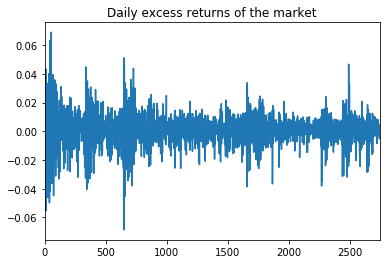

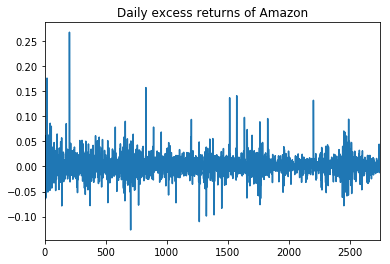

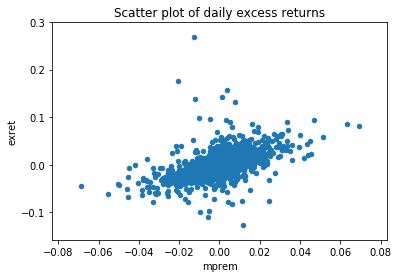

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  exret   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     1104.
Date:                Thu, 19 Mar 2020   Prob (F-statistic):          9.12e-204
Time:                        23:14:18   Log-Likelihood:                 7161.2
No. Observations:                2747   AIC:                        -1.432e+04
Df Residuals:                    2745   BIC:                        -1.431e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.675      0.008       0.000       0.002
mprem          1.0925      0.033     33.227      0.000       1.028       1.157
==============================================================================
Omnibus:                     1858.560   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           166729.399
Skew:                           2.403   Prob(JB):                         0.00
Kurtosis:                      40.863   Cond. No.                         96.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

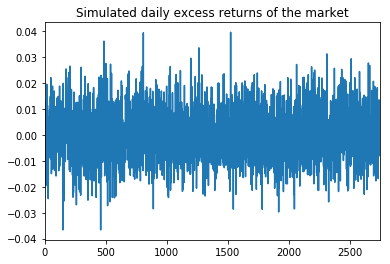

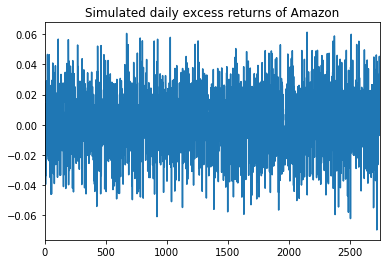

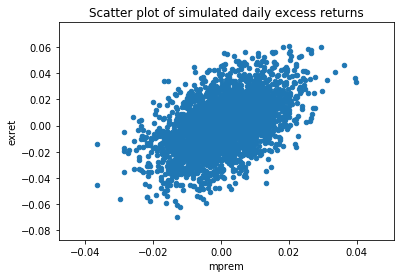

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

MKT='mprem'
STK='exret'

# create excess returns
ret['exret']=ret['ret']-ret['tdyld']
ret['mprem']=ret['vwretd']-ret['tdyld']

# Parameters
num_tdays=252
len_win=126

display(ret.describe())

#Plot the time series of real data
ret['mprem'].plot(label=MKT,title='Daily excess returns of the market')
plt.show() 
ret['exret'].plot(label=STK,title='Daily excess returns of Amazon')
plt.show() 

ret.plot(y='exret', x='mprem',kind='scatter',title='Scatter plot of daily excess returns')
plt.show() 

#Run an OLS regression
ret['const']=1
reg1= sm.OLS(endog=ret['exret'],exog=ret[['const','mprem']],missing='drop')

results=reg1.fit()
display(results.summary())

#Looking ahead to question (c), let's simulate the CAPM
Rf=data_Rf.mean().values
mx_cov = np.cov(ret['exret'],ret['mprem'],ddof=1)

MKT_mu = ret['mprem'].mean()
STK_mu = ret['exret'].mean()

beta = mx_cov[0,1]/mx_cov[1,1]
MKT_tot_risk = mx_cov[1,1]
STK_tot_risk = mx_cov[0,0]
STK_syst_risk = beta**2*MKT_tot_risk
STK_idio_risk = STK_tot_risk-STK_syst_risk

sim_MKT = MKT_mu + np.random.normal(0,np.sqrt(MKT_tot_risk),len(ret.index))
sim_EPS = np.random.normal(0,np.sqrt(STK_idio_risk),len(ret.index))
sim_STK = beta*(sim_MKT-Rf) + sim_EPS

ret_sim = pd.DataFrame({'exret': sim_STK, 'mprem': sim_MKT}, index=ret.index)

#Plot the time series of simulated data
ret_sim['mprem'].plot(label='market',title='Simulated daily excess returns of the market')
plt.show() 
ret_sim['exret'].plot(label='Amazon',title='Simulated daily excess returns of Amazon')
plt.show() 

ret_sim.plot(y='exret', x='mprem',kind='scatter',title='Scatter plot of simulated daily excess returns')
plt.show()


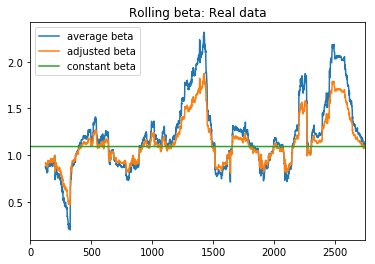

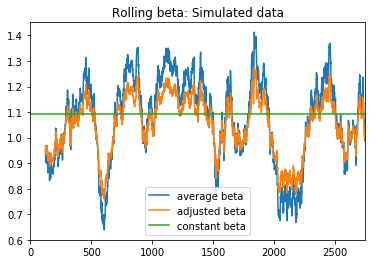

In [9]:
import numpy as np
import pandas as pd


for i in range(2): 
    if (i==0): 
        data = ret
        fig_title='Rolling beta: Real data'
    else: 
        data = ret_sim
        fig_title='Rolling beta: Simulated data'
    
    ts_cov=data['exret'].rolling(window=len_win).cov(data['mprem'].rolling(window=len_win))
    ts_var=data['mprem'].rolling(window=len_win).var()
    
    ts_beta=ts_cov/ts_var
    ts_beta_adj=pd.Series(np.multiply(ts_beta,2/3)+1/3,ts_beta.index)
    ts_beta_const=pd.Series(beta,ts_beta.index)
    
    ts_beta.plot(label='average beta',title=fig_title)
    ts_beta_adj.plot(label='adjusted beta',title=fig_title)
    ts_beta_const.plot(label='constant beta',title=fig_title)
    plt.legend()
    plt.show()


In [2]:
#EXERCISE 2

# Problem 4

In [8]:
import numpy as np
mu    = np.array([0.08, 0.10, 0.12])
sigma = np.array([0.15, 0.25, 0.30])
ones=np.ones(3)

R0    = 0.05

cov   = np.array([[ 0.01,0.0015,0.002],\
        [0.0015,0.0225,0.003],\
        [0.002,0.003,0.04]])
ones=np.ones(3)
ax=5

w=1/ax*np.linalg.inv(cov)@(mu-R0)
wm=w/(ones@w)

mum=wm@mu
stdm=np.sqrt(wm@cov@wm)
am=ax*ones@w
wy=w/(ones@w)*(2-ones@w)
print('The first investor invests as follows: ', w)
print('The first investor borrows ',ones@w-1)


print('The market portfolio is: ', wm)
print('The market-wide risk aversion is ',am)
print('The mean return of the market portfolio is: ',mum)
print('The standard deviation of the market portfolio is: ',stdm)
print('The second investor invests as follows: ',wy)
print('The risk aversion of the second investor is: ',am/(2-ones@w))
#print(am/(ones@wy))

The first investor invests as follows:  [0.4845679  0.37242798 0.29783951]
The first investor borrows  0.15483539094650212
The market portfolio is:  [0.41959911 0.32249443 0.25790646]
The market-wide risk aversion is  5.774176954732511
The mean return of the market portfolio is:  0.09676614699331848
The standard deviation of the market portfolio is:  0.08999549098084277
The second investor invests as follows:  [0.35463032 0.27256088 0.21797341]
The risk aversion of the second investor is:  6.832014607425442
